# Explaining Model Predictions with Accumulated Local Effects Plot (ALE)

## **1. Introduction**

- In this notebook, we shall explore ALE, a post-hoc explainability method that examines the relationship between a feature (or features) and the model’s predictions, while accounting for potential dependencies between features -- which PDP as we saw may not be able to do. 
- What are the key concepts of ALE ?

    - ALE focuses on local effects i.e. examining the small,  localized changes of a feature while keeping all other features constant (or marginalizing over them)
    - The local effects are integrated (accumulated) over the feature’s value range to understand the global effect of the feature on predictions.
    - ALE plots are centered around zero ensuring the visualized effects represent deviations from the average prediction.

- At a high level, these are the steps to plot the ALE:

    1.	**Bin the Feature:**
	    -	Divide the range of the feature into intervals (bins).
	2.	**Compute Local Effects:**
	    -	For each interval, calculate the effect of moving the feature value from one side of the interval to the other while keeping other features constant.
	3.	**Accumulate Effects:**
	    - 	Integrate (accumulate) the local effects across all intervals.
	4.	**Center the Plot:**
	    -	Subtract the mean of the accumulated effects to center the ALE curve around zero.

This technique was introduced in the paper:

 Apley, Daniel W., and Jingyu Zhu. 2020. “Visualizing the Effects of Predictor Variables in Black Box Supervised Learning Models.” Journal of the Royal Statistical Society Series B: Statistical Methodology 82 (4): 1059–86. https://doi.org/10.1111/rssb.12377


## **2. Import the necessary libraries**

We are specifically ging to be using PyALE, a library in Python that implements ALE. 

In [1]:
import pandas as pd
from PyALE import ale

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,auc,roc_curve,roc_auc_score  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default') 

## **3. Loading the dataset**

We are using a Bank Marketing Dataset from a Portuguese banking institution. There are 16 direct marketing (phone calls related) features from 45,211 clients and task is to  classify if client will subscribe a term deposit or not. 
Dataset URL:  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip



In [2]:
df = pd.read_csv('../datasets/bank_marketing/bank-full.csv', delimiter=';')   
display(df.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## **4.Pre-process the dataset**

In [3]:


# Automatically determine categorical and numerical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


# Remove the target variable (if included in the dataset)
target_variable = "y"
if target_variable in categorical_features:
    categorical_features.remove(target_variable)
if target_variable in numerical_features:
    numerical_features.remove(target_variable)
    
# Define the ColumnTransformer
one_hot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, numerical_features),   # Scale numerical features
        ("cat", one_hot_encoder, categorical_features)  # One-hot encode categorical features
    ]
)

# Separate features and target
X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Convert true labels to binary format
y= (y == 'yes').astype(int)

# Apply the transformation to features
processed_X = preprocessor.fit_transform(X)

# Extract the fitted OneHotEncoder
one_hot_encoder = preprocessor.named_transformers_["cat"]

# Get one-hot encoded column names
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(categorical_features)

# Combine with scaled numerical column names
final_column_names = numerical_features + list(one_hot_encoded_columns)
print(f"Final colum names after preprocessing: {final_column_names}")

# Create a DataFrame with the transformed data
processed_X_df = pd.DataFrame(processed_X, columns=final_column_names)

# Display the DataFrame
display(processed_X_df.head())


Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Final colum names after preprocessing: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_o

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## **5. Let's train a Logistic Regression Model on this dataset**

Accuracy Score: 0.901249585314608
AUC Score: 0.9055873903455556


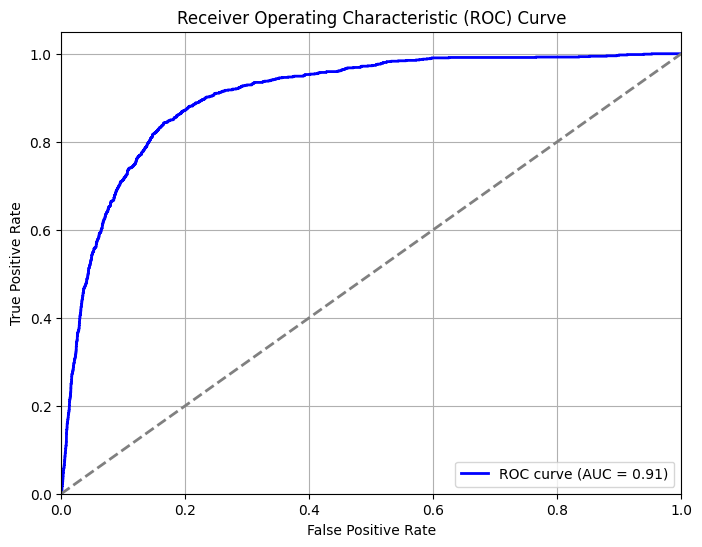

In [4]:


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(processed_X_df, y, test_size=0.2, stratify=y, random_state=42)

#create a model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

logit_fun = model.decision_function
proba_fun = model.predict_proba


y_probs = proba_fun(X_test)[:, 1]

# Convert probabilities to binary predictions
y_pred = (y_probs >= 0.5).astype(int)

# Compute accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_probs)

print("Accuracy Score:", accuracy)
print("AUC Score:", auc_score)


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
plt.close()



## **6.ALE plots**

Let us now use pyALE to explain the predictions of this classifier. We will start by analysisng the effects of individial features:

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


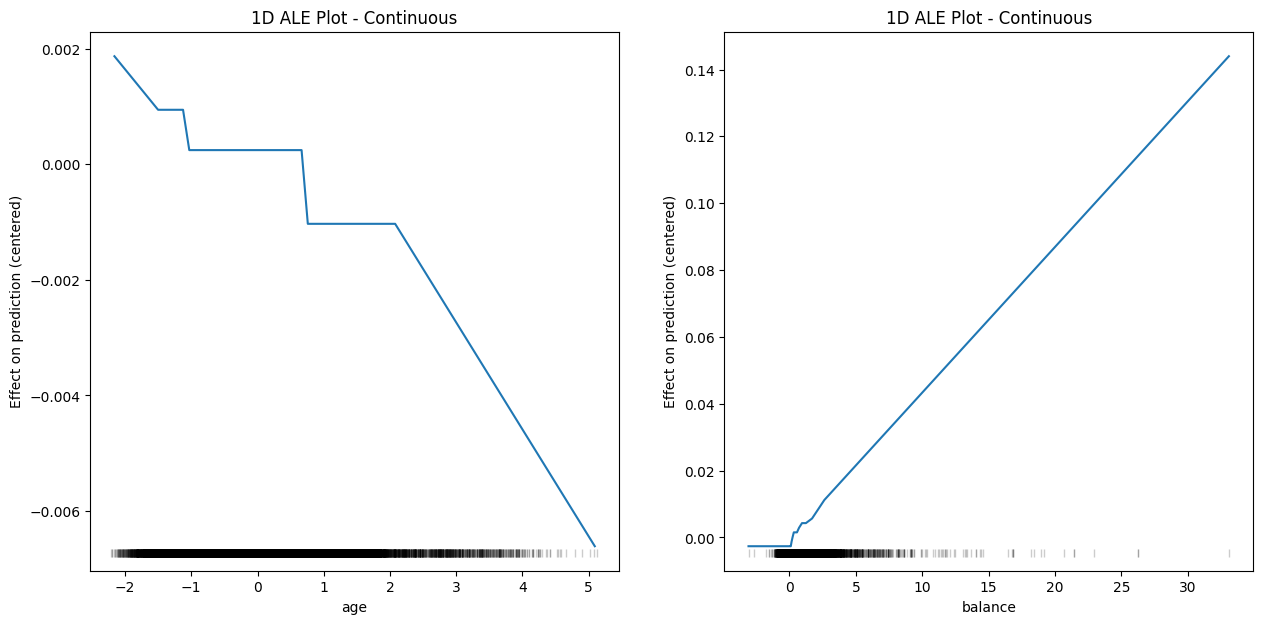

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_effects_age = ale(X_train, model=model, feature=["age"], grid_size=50,include_CI=False,fig=fig,ax=ax1)
ale_effects_loan = ale(X_train, model=model, feature=["balance"], grid_size=50,include_CI=False,fig=fig,ax=ax2)
plt.show()


1. **ALE:  age feature**
	- 	The plot shows a slight downward trend as age increases.
	- 	This means that higher age values reduce the model’s prediction marginally.
	- 	The rug plot at the bottom indicates where most of the data points lie (densely clustered near 0). Sparse data at higher age values suggests limited information for the model to learn strong effects in this range.
  
2. **ALE: balance feature**
	- 	As balance increases, the ALE curve shows a sharp positive trend.
	- 	This suggests that higher values of balance significantly increase the model’s prediction.
	- 	Rug plot (bottom) shows most data points are concentrated at lower values of balance, with sparse data at higher values. The steep rise at high balance values should be interpreted cautiously, as there might be fewer data points in this region.

3. **Interpretation**
	- 	age: Further domain knowledge could explain why older individuals contribute negatively to the outcome.
	- 	balance: This is likely a highly important feature for the model. Ensure that the model is not overfitting to the few high-balance examples, as the sharp rise suggests potential sensitivity in this range.

PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.


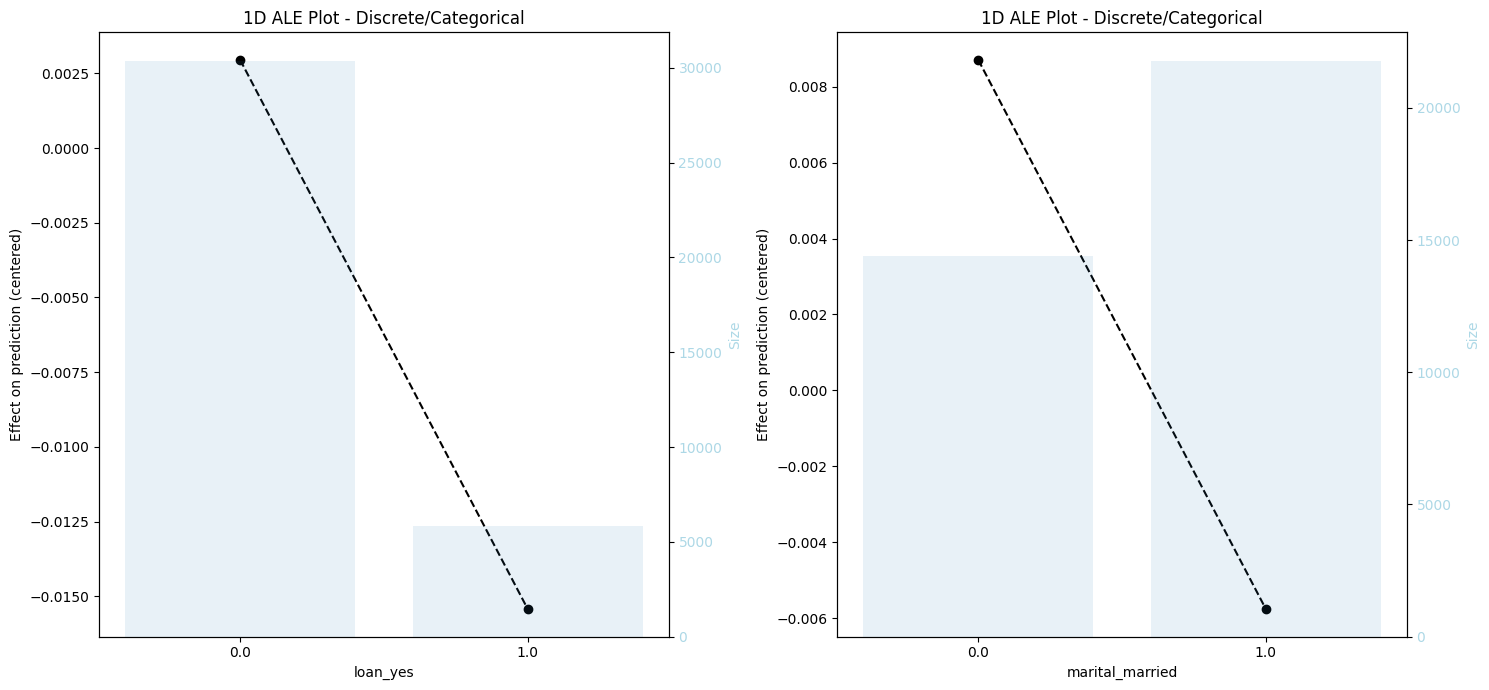

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_effects_age = ale(X_train, model=model, feature=["loan_yes"], grid_size=50,include_CI=False,fig=fig,ax=ax1)
ale_effects_loan = ale(X_train, model=model, feature=["marital_married"], grid_size=50,include_CI=False,fig=fig,ax=ax2)
plt.show()

These ALE plots for categorical variables show how the presence or absence of specific categories (encoded as 0 and 1) influence the model’s predictions. Here’s how to interpret them:

1. Left Plot: loan_yes
	- 	Effect on Prediction:
		- 	When loan_yes = 0 (no loan), the effect on the model’s prediction is positive (~0.0025).
		- 	When loan_yes = 1 (has a loan), the effect is significantly negative (~-0.015).
	- 	Interpretation:
		- 	The model predicts lower outcomes for individuals who have a loan (loan_yes = 1) compared to those who do not.
		- 	This could indicate that having a loan is a negative factor for the prediction target (e.g., likelihood of success, repayment, or a similar outcome).
	- 	Distribution:
		- 	The light blue bar in the background indicates the number of samples (size) for each category.
		- 	Most samples are concentrated in the loan_yes = 0 category, with fewer samples in loan_yes = 1.

2. Right Plot: marital_married
	- 	Effect on Prediction:
		- 	When marital_married = 0 (not married), the effect on the model’s prediction is positive (~0.01).
		- 	When marital_married = 1 (married), the effect is negative (~-0.007).
	- 	Interpretation:
		- 	The model predicts higher outcomes for individuals who are not married compared to those who are.
		- 	This suggests that marital status has a noticeable impact on the target variable, with being married contributing negatively.
	- 	Distribution:
		- 	The light blue bar shows that more samples belong to the marital_married = 1 category, meaning the majority of individuals in the dataset are married.

**General Observations**

1.	Imbalance in Data Distribution:
	- 	Both plots show imbalances in the sample size for the two categories.
	- 	The imbalances could affect the reliability of the ALE effects, especially for categories with fewer samples (loan_yes = 1).

2.	Centered Effects:
	- 	The effects are centered around 0, making it easier to interpret the relative importance of each category.

3.	Implications:
	- 	For loan_yes: Having a loan has a strong negative effect, indicating it could be a key feature in the model.
	- 	For marital_married: Marital status also plays a role, but the negative effect for married individuals suggests an interesting relationship worth investigating further.
